In [1]:
import os 
import re 
import numpy as np 
import matplotlib.pyplot as plt 
import rasterio 
import pandas as pd 
from pathlib import Path 
import seaborn as sns 
from datetime import datetime
from tqdm import tqdm 

In [2]:
class BigEarthNetExplorer:
    def __init__(self, root_dir):
        self.root_dir = Path(root_dir) / 'BigEarthNet-S2' / 'BigEarthNet-S2'
        print(f"Initialized with directory: {self.root_dir}")
        
        self.band_info = {
            'B01': {'resolution': 60, 'description': 'Coastal aerosol'},
            'B02': {'resolution': 10, 'description': 'Blue'},
            'B03': {'resolution': 10, 'description': 'Green'},
            'B04': {'resolution': 10, 'description': 'Red'},
            'B05': {'resolution': 20, 'description': 'Vegetation red edge'},
            'B06': {'resolution': 20, 'description': 'Vegetation red edge'},
            'B07': {'resolution': 20, 'description': 'Vegetation red edge'},
            'B08': {'resolution': 10, 'description': 'NIR'},
            'B09': {'resolution': 60, 'description': 'Water vapor'},
            'B11': {'resolution': 20, 'description': 'SWIR'},
            'B12': {'resolution': 20, 'description': 'SWIR'},
            'B8A': {'resolution': 20, 'description': 'Narrow NIR'}
        }

    def find_patch_subdirectories(self, patch_id):
        """Find all subdirectories for a given patch"""
        patch_dir = self.root_dir / patch_id
        return [d for d in patch_dir.iterdir() if d.is_dir()]

    def parse_patch_name(self, patch_name):
        """Parse metadata from patch directory name"""
        pattern = r'S2([AB])_MSIL2A_(\d{8})T(\d{6})_N(\d{4})_R(\d{3})_T(\w+)'
        match = re.match(pattern, patch_name)
        
        if match:
            satellite, date_str, time_str, processing, orbit, tile = match.groups()
            
            datetime_str = f"{date_str}T{time_str}"
            acquisition_time = datetime.strptime(datetime_str, "%Y%m%dT%H%M%S")
            
            return {
                'satellite': f'S2{satellite}',
                'acquisition_date': acquisition_time.date(),
                'acquisition_time': acquisition_time.time(),
                'processing_baseline': processing,
                'orbit_number': int(orbit),
                'tile_number': tile,
                'patch_name': patch_name
            }
        return None

    def load_single_patch(self, patch_id, subdir_index=0):
        """Load all bands for a single patch from a specific subdirectory"""
        # Get all subdirectories for this patch
        subdirs = self.find_patch_subdirectories(patch_id)
        if not subdirs:
            print(f"No subdirectories found for patch {patch_id}")
            return None, None
        
        # Use the specified subdirectory
        patch_subdir = subdirs[subdir_index]
        print(f"Loading from subdirectory: {patch_subdir}")
        
        bands = {}
        metadata = self.parse_patch_name(patch_id)
        if metadata:
            metadata['subdir'] = patch_subdir.name
        
        # Load each band
        for band_name in self.band_info.keys():
            # Find the corresponding .tif file
            tif_files = list(patch_subdir.glob(f"*{band_name}.tif"))
            if tif_files:
                try:
                    with rasterio.open(tif_files[0]) as src:
                        bands[band_name] = src.read(1)
                except Exception as e:
                    print(f"Error reading band {band_name}: {e}")
                    return None, None
            else:
                print(f"Band {band_name} not found in {patch_subdir}")
                return None, None
                
        return bands, metadata

    def visualize_patch_with_metadata(self, patch_id, subdir_index=0):
        """Visualize patch with its metadata"""
        bands, metadata = self.load_single_patch(patch_id, subdir_index)
        if bands is None or metadata is None:
            print(f"Failed to load patch {patch_id}")
            return
            
        # Create RGB composite
        rgb = np.stack([
            bands['B04'],  # Red
            bands['B03'],  # Green
            bands['B02']   # Blue
        ])
        
        # Normalize for visualization
        rgb = np.clip(rgb / 3000, 0, 1)
        
        # Create figure with two subplots
        fig = plt.figure(figsize=(15, 8))
        
        # Plot RGB image
        plt.subplot(1, 2, 1)
        plt.imshow(rgb.transpose(1, 2, 0))
        plt.title(f"RGB Composite\nSubdirectory: {metadata['subdir']}")
        plt.axis('off')
        
        # Display metadata
        plt.subplot(1, 2, 2)
        plt.axis('off')
        metadata_text = "\n".join([
            f"Satellite: {metadata['satellite']}",
            f"Acquisition Date: {metadata['acquisition_date']}",
            f"Acquisition Time: {metadata['acquisition_time']}",
            f"Orbit Number: {metadata['orbit_number']}",
            f"Tile Number: {metadata['tile_number']}",
            f"Subdirectory: {metadata['subdir']}"
        ])
        plt.text(0.1, 0.5, metadata_text, fontsize=12, va='center')
        
        plt.tight_layout()
        plt.show()

In [3]:
explorer = BigEarthNetExplorer(os.getcwd())

Initialized with directory: c:\Users\kimki\Downloads\SRGAN_Satellite\BigEarthNet-S2\BigEarthNet-S2


Available patches:

Patch 1: S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP
Subdirectories: ['S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_56', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_57', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_58', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_59', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_60', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_61', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_28_55', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_28_56', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_28_57', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_28_58', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_28_59', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_28_60', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_28_61', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_28_62', 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP

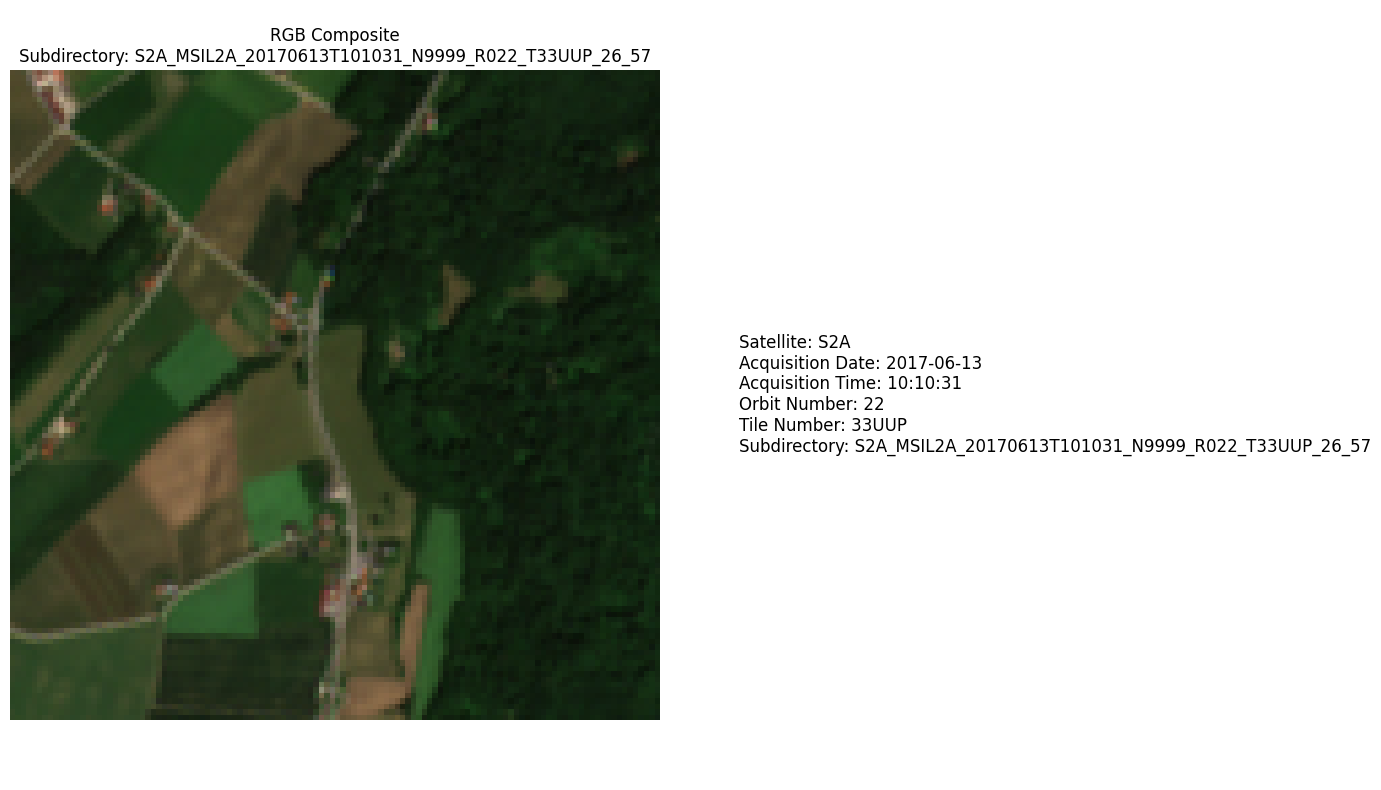

In [4]:
print("Available patches:")
patches = [d.name for d in explorer.root_dir.iterdir() if d.is_dir()]
for i, patch in enumerate(patches[:5]):  # Show first 5 patches
    subdirs = explorer.find_patch_subdirectories(patch)
    print(f"\nPatch {i+1}: {patch}")
    print(f"Subdirectories: {[d.name for d in subdirs]}")

# Try to visualize the first patch
if patches:
    first_patch = patches[0]
    print(f"\nVisualizing first patch: {first_patch}")
    
    # Show all subdirectories for this patch
    subdirs = explorer.find_patch_subdirectories(first_patch)
    print(f"Available subdirectories: {[d.name for d in subdirs]}")
    
    # Visualize from first subdirectory
    explorer.visualize_patch_with_metadata(first_patch, subdir_index=0)

In [5]:
class BigEarthNetAnalyzer:
    def __init__(self, explorer):
        self.explorer = explorer
        
    def analyze_band_statistics(self, patch_id, subdir_index=0):
        """Analyze statistics for all bands in a patch"""
        bands, metadata = self.explorer.load_single_patch(patch_id, subdir_index)
        if bands is None:
            return None
            
        stats = {}
        for band_name, band_data in bands.items():
            stats[band_name] = {
                'min': band_data.min(),
                'max': band_data.max(),
                'mean': band_data.mean(),
                'std': band_data.std(),
                'resolution': self.explorer.band_info[band_name]['resolution'],
                'shape': band_data.shape
            }
        
        return pd.DataFrame(stats).transpose()
    
    def visualize_all_bands(self, patch_id, subdir_index=0):
        """Visualize all bands separately"""
        bands, metadata = self.explorer.load_single_patch(patch_id, subdir_index)
        if bands is None:
            return
            
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        axes = axes.ravel()
        
        for idx, (band_name, band_data) in enumerate(bands.items()):
            # Normalize for visualization
            band_vis = np.clip(band_data / band_data.max(), 0, 1)
            
            axes[idx].imshow(band_vis, cmap='viridis')
            axes[idx].set_title(f"{band_name}\n"
                              f"{self.explorer.band_info[band_name]['description']}\n"
                              f"{self.explorer.band_info[band_name]['resolution']}m\n"
                              f"Shape: {band_data.shape}")
            axes[idx].axis('off')
            
        plt.tight_layout()
        plt.show()
        
    def analyze_resolution_groups(self, patch_id, subdir_index=0):
        """Group and analyze bands by resolution"""
        bands, _ = self.explorer.load_single_patch(patch_id, subdir_index)
        if bands is None:
            return
            
        # Group bands by resolution
        resolution_groups = {
            '10m': ['B02', 'B03', 'B04', 'B08'],
            '20m': ['B05', 'B06', 'B07', 'B11', 'B12', 'B8A'],
            '60m': ['B01', 'B09']
        }
        
        print("Band resolution analysis:")
        for res, band_list in resolution_groups.items():
            print(f"\n{res} resolution bands:")
            for band in band_list:
                if band in bands:
                    data = bands[band]
                    print(f"{band} - Shape: {data.shape}, "
                          f"Range: [{data.min():.2f}, {data.max():.2f}], "
                          f"Mean: {data.mean():.2f}")
    
    def plot_band_histograms(self, patch_id, subdir_index=0):
        """Plot histograms for all bands"""
        bands, _ = self.explorer.load_single_patch(patch_id, subdir_index)
        if bands is None:
            return
            
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        axes = axes.ravel()
        
        for idx, (band_name, band_data) in enumerate(bands.items()):
            axes[idx].hist(band_data.ravel(), bins=50, alpha=0.7)
            axes[idx].set_title(f"{band_name} Distribution")
            axes[idx].set_xlabel('Pixel Value')
            axes[idx].set_ylabel('Frequency')
            
        plt.tight_layout()
        plt.show()

Analyzing patch: S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP

Visualizing all bands:
Loading from subdirectory: c:\Users\kimki\Downloads\SRGAN_Satellite\BigEarthNet-S2\BigEarthNet-S2\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57


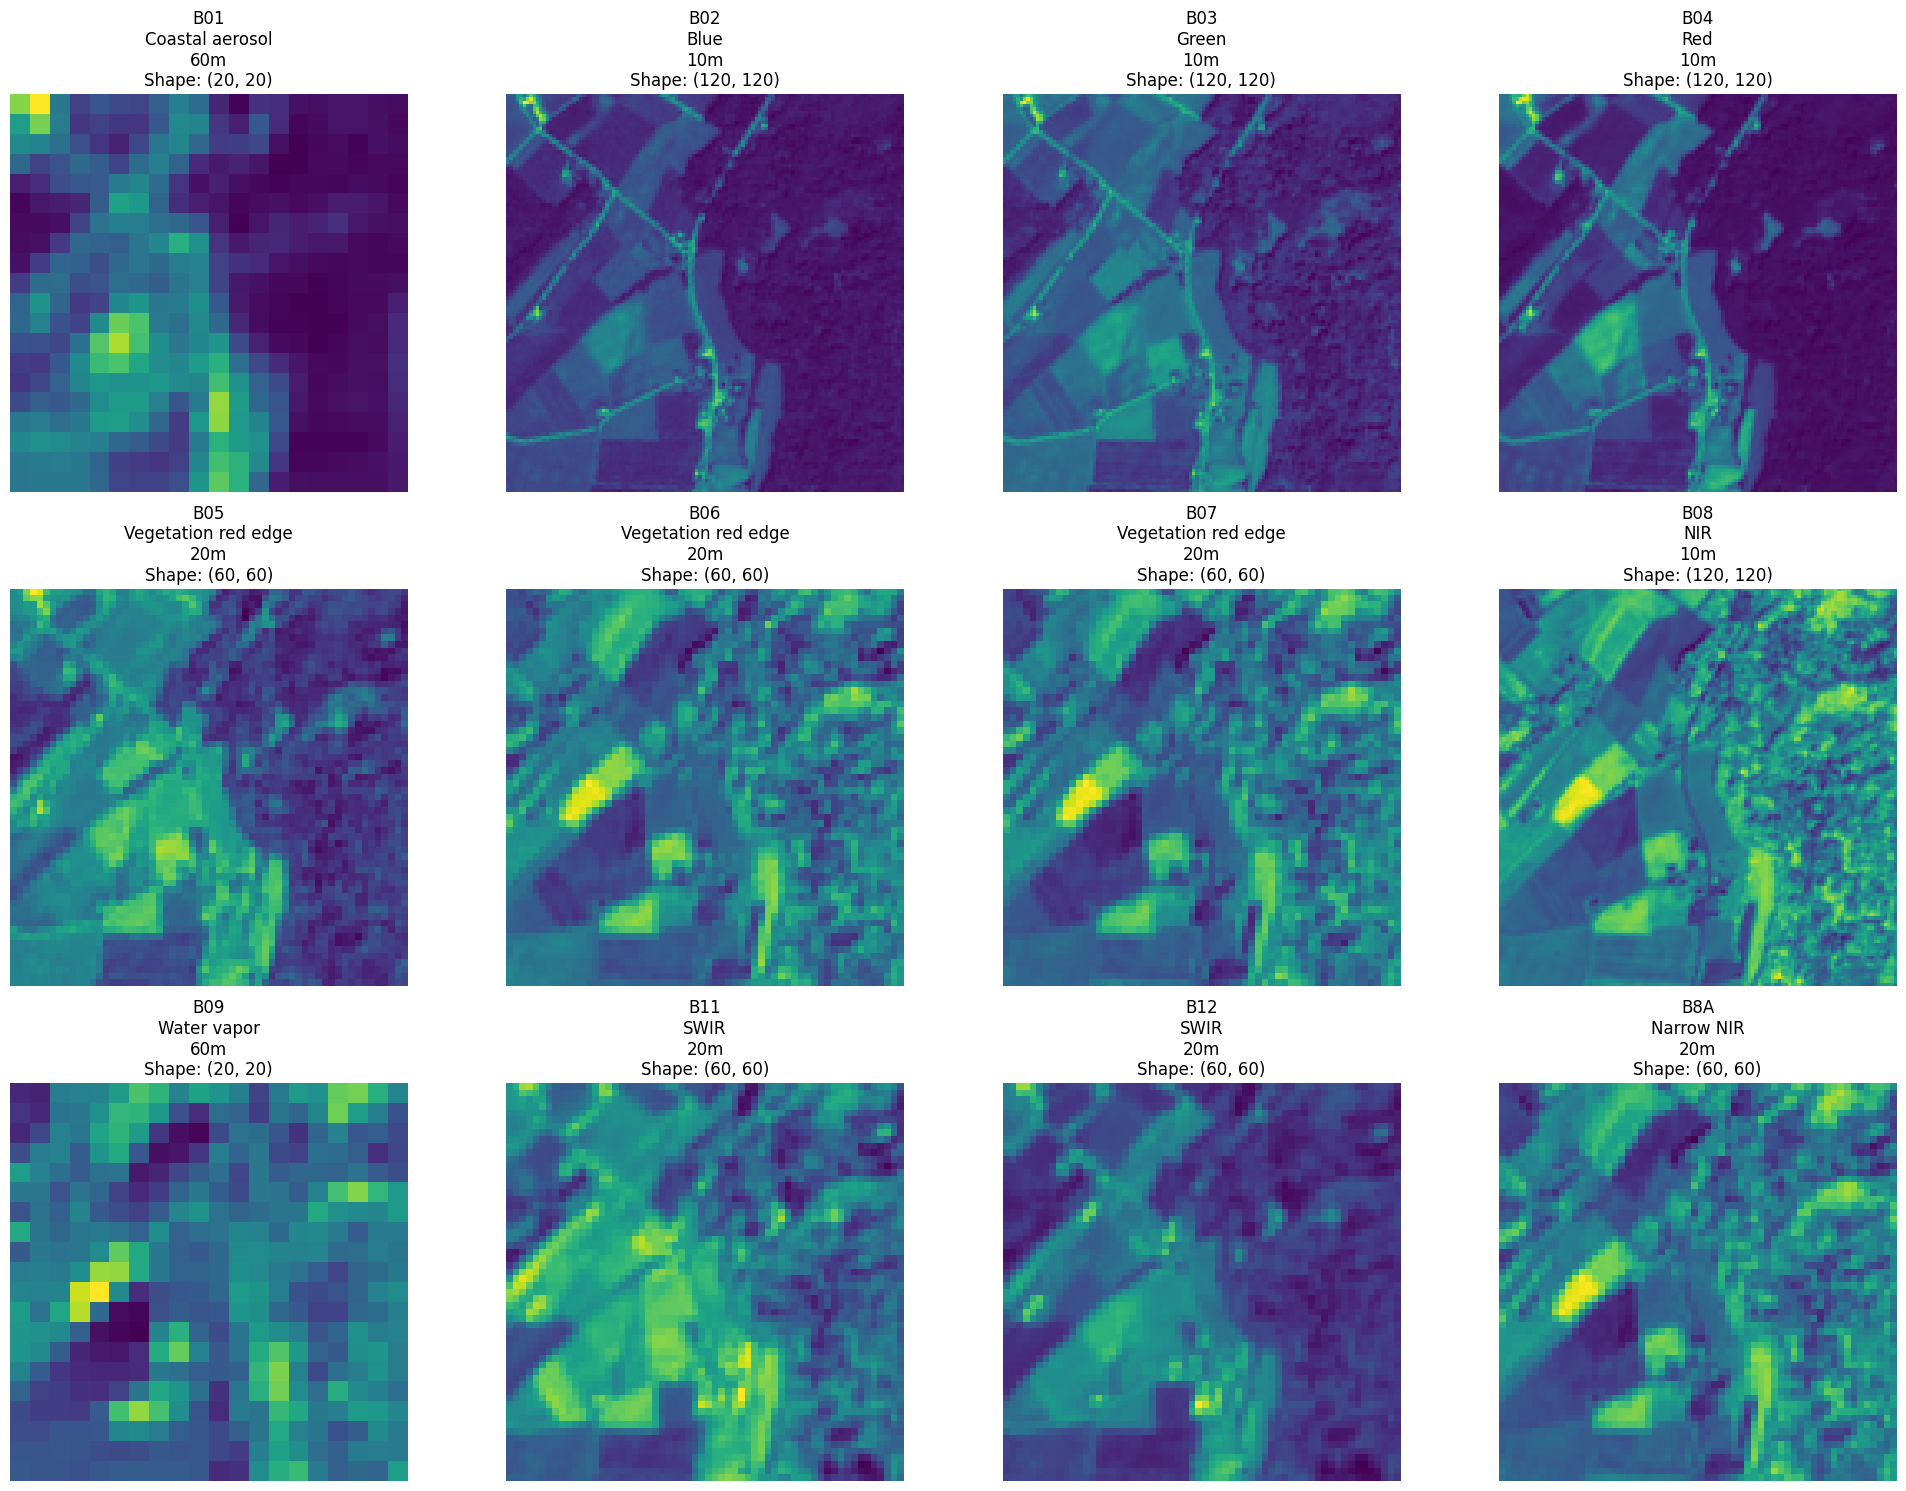


Band statistics:
Loading from subdirectory: c:\Users\kimki\Downloads\SRGAN_Satellite\BigEarthNet-S2\BigEarthNet-S2\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
      min   max         mean         std resolution       shape
B01   171   785      314.715  127.186571         60    (20, 20)
B02    80  1736    341.57625  196.757586         10  (120, 120)
B03   190  2060   638.639722  262.615599         10  (120, 120)
B04   105  2322   477.615139  343.519335         10  (120, 120)
B05   384  2276    1042.6525  363.527933         20    (60, 60)
B06  1215  5324  2849.992778  662.717417         20    (60, 60)
B07  1467  6609  3454.128611  854.119922         20    (60, 60)
B08  1021  6808  3610.564514  958.727917         10  (120, 120)
B09  2047  6405      3692.39  726.789824         60    (20, 20)
B11   818  3401  1951.604444  484.089312         20    (60, 60)
B12   323  3044  1070.142778  435.564494         20    (60, 60)
B8A  1558  6794  369

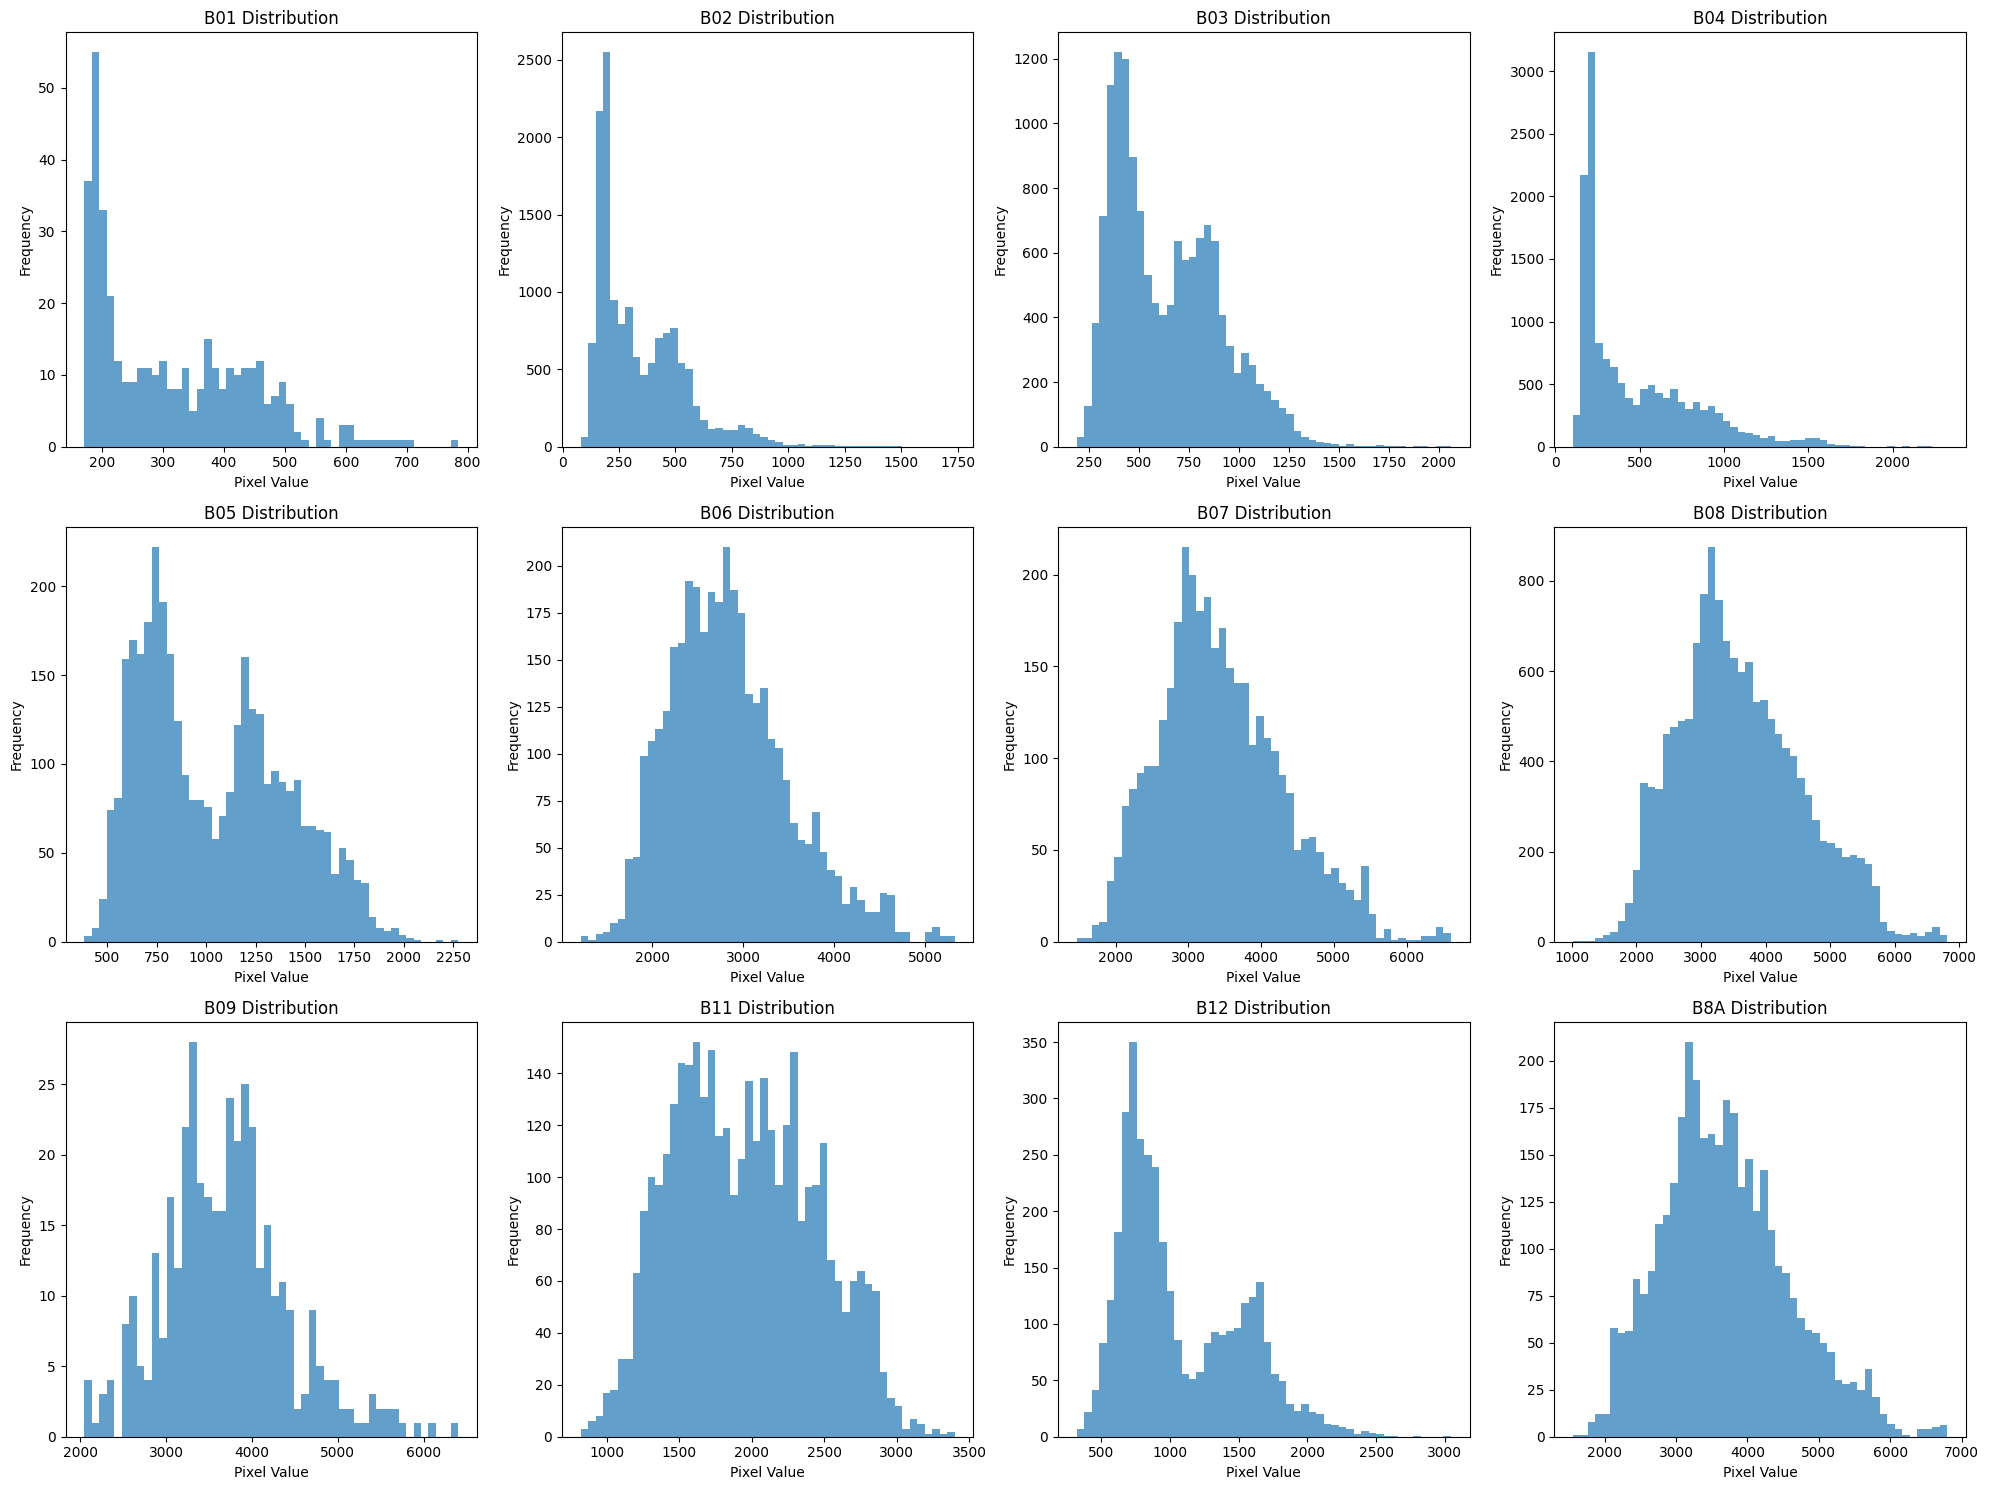


Key observations for SRGAN design:
1. Input bands (20m, 60m):
   - B05, B06, B07, B11, B12, B8A (20m)
   - B01, B09 (60m)
2. Target bands (10m):
   - B02, B03, B04, B08


In [6]:
analyzer = BigEarthNetAnalyzer(explorer)

# Get a list of patches
patches = [d.name for d in explorer.root_dir.iterdir() if d.is_dir()]
if patches:
    first_patch = patches[0]
    print(f"Analyzing patch: {first_patch}")
    
    # 1. Show all bands
    print("\nVisualizing all bands:")
    analyzer.visualize_all_bands(first_patch)
    
    # 2. Show band statistics
    print("\nBand statistics:")
    stats_df = analyzer.analyze_band_statistics(first_patch)
    print(stats_df)
    
    # 3. Resolution group analysis
    print("\nResolution group analysis:")
    analyzer.analyze_resolution_groups(first_patch)
    
    # 4. Plot band histograms
    print("\nPlotting band histograms:")
    analyzer.plot_band_histograms(first_patch)
    
    print("\nKey observations for SRGAN design:")
    print("1. Input bands (20m, 60m):")
    print("   - B05, B06, B07, B11, B12, B8A (20m)")
    print("   - B01, B09 (60m)")
    print("2. Target bands (10m):")
    print("   - B02, B03, B04, B08")